# if on colab

In [1]:
# !git clone https://github.com/Hen0k/causal-inference.git
# %cd "causal-inference/notebooks"
# !apt-get install graphviz graphviz-dev -q
# !pip install pygraphviz -q
# !pip install causalnex -q

# Handle Imports

In [40]:
import sys
sys.path.append("../scripts/")

from IPython.display import Image

import warnings
from causalnex.structure.notears import from_pandas, from_pandas_lasso
from causalnex.plots import plot_structure, NODE_STYLE, EDGE_STYLE
from causalnex.discretiser import Discretiser

import networkx as nx

warnings.filterwarnings("ignore")  # silence warnings

# custom modules import
from fetch_data import DataLoader
from visualization import Plotters


loader = DataLoader()
plotters = Plotters(w=10, h=10)

# Learning the Structure

As the number of variables grows, or when domain knowledge does not exist, it can be tedious to define a structure manually. We can use CausalNex to learn the structure model from data. The structure learning algorithm we are going to use here is the NOTEARS algorithm.

When learning structure, we can use the entire dataset. Since structure should be considered as a joint effort between machine learning and domain experts, it is not always necessary to use a train / test split.

But before we begin, we have to pre-process the data so that the NOTEARS algorithm can be used.

In [3]:
data = loader.dvc_get_data(path="./data/data.csv",
                                  version="cleaned_data",
                                  repo="../")
cols_to_keep = ['perimeter_mean',
                'perimeter_worst',
                'area_se',
                'area_mean',
                'area_worst']
struct_data = data[cols_to_keep]
struct_data["target"] = data["diagnosis"]


DVC: CSV file read with path: ./data/data.csv | version: cleaned_data | from: ../


In [4]:
struct_data.head()

,perimeter_mean,perimeter_worst,area_se,area_mean,area_worst,target
0,122.80,184.60,153.40,1001.0,2019.0,1
1,132.90,158.80,74.08,1326.0,1956.0,1
2,130.00,152.50,94.03,1203.0,1709.0,1
3,77.58,98.87,27.23,386.1,567.7,1
4,135.10,152.20,94.44,1297.0,1575.0,1


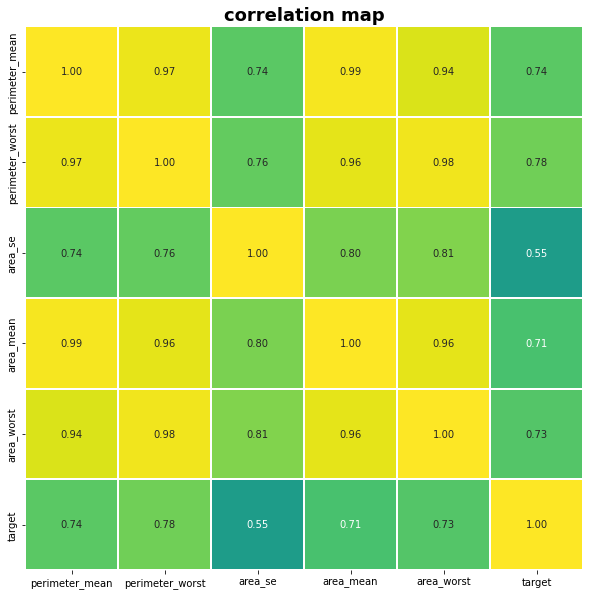

In [5]:
plotters.plot_heatmap(struct_data.corr(), "correlation map")

# Split the data
start at 50%, use it to generate the graph and gradually add portions of the holdout set to test the graphs stability

In [7]:
struct_data.shape

(569, 6)

In [9]:
train_set = struct_data.iloc[:len(struct_data)//2, :]
holdout_set = struct_data.iloc[len(struct_data)//2:, :]
print(f"Train set shape: {train_set.shape}\nHoldout set shape: {holdout_set.shape}")

Train set shape: (284, 6)
Holdout set shape: (285, 6)


In [23]:
sm = from_pandas(train_set,
                 w_threshold=0.8,
                 )


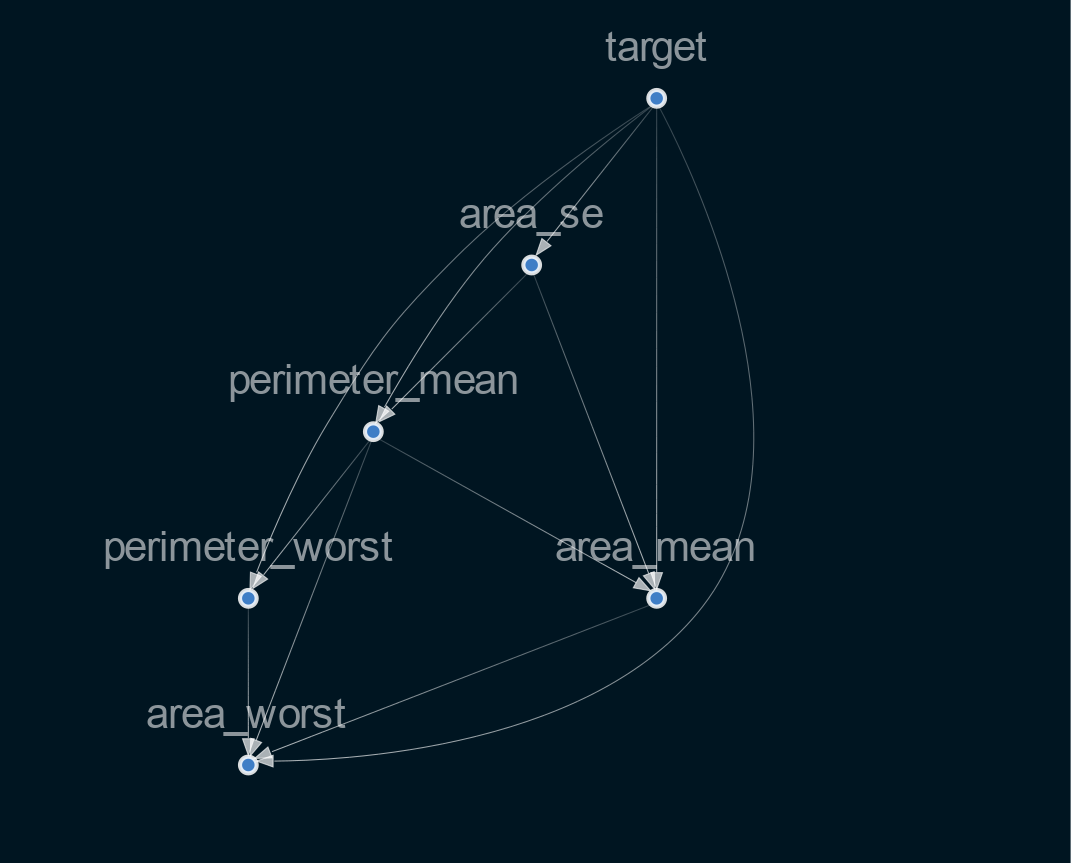

In [80]:
viz = plot_structure(
    sm,
    graph_attributes={"scale": "1", "size": "5"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK,
    prog='dot',
)
Image(viz.draw(format='png'))

In [25]:
# 

# nx.drawing.nx_pydot.write_dot(sm, '../../graph.dot')

In [43]:
# sm = from_pandas_lasso(struct_data, beta=0.01, w_threshold=0.8, )

In [62]:
sm_r = sm.reverse()

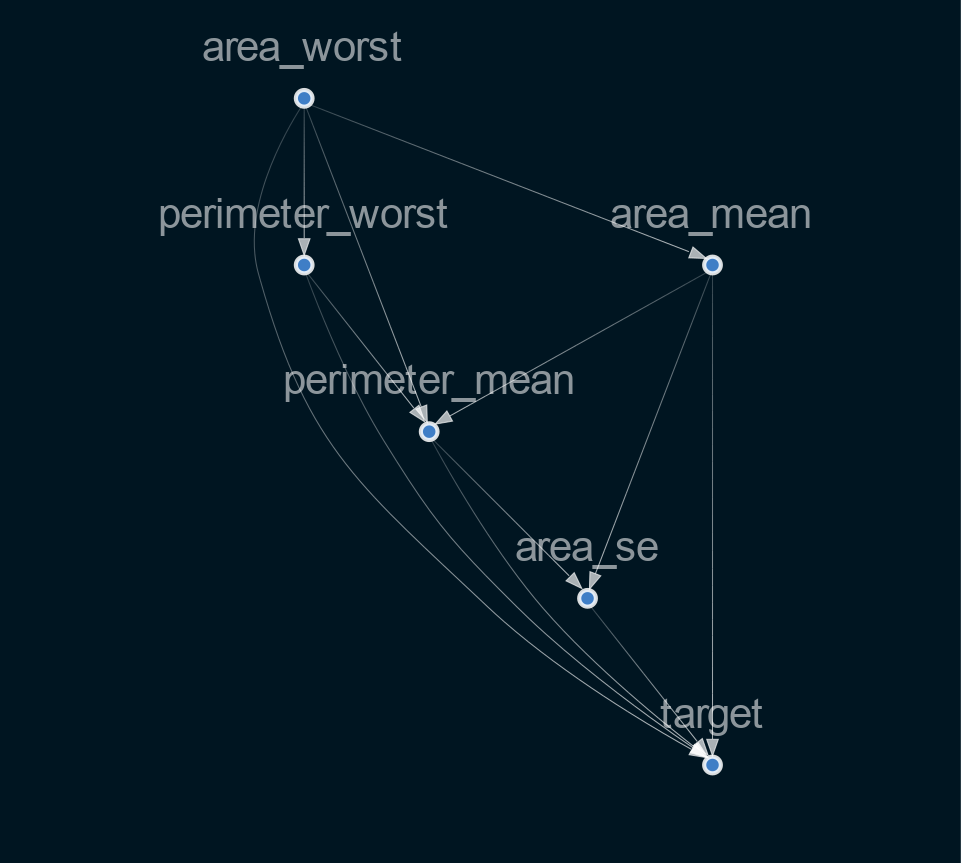

In [81]:
# sm.remove_edges_below_threshold(0.8)
viz = plot_structure(
    sm_r,
    graph_attributes={"scale": "1", "size":"5"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK,
    prog="dot",
)
Image(viz.draw(format='png'))

In [83]:
viz.draw("reports/causal_graph.png")

In [65]:
from causalnex.network import BayesianNetwork
# sm = sm.get_largest_subgraph()
bn = BayesianNetwork(sm)

# Discritize

In [66]:

discretised_data = train_set.copy()
discretised_data.head()

,perimeter_mean,perimeter_worst,area_se,area_mean,area_worst,target
0,122.80,184.60,153.40,1001.0,2019.0,1
1,132.90,158.80,74.08,1326.0,1956.0,1
2,130.00,152.50,94.03,1203.0,1709.0,1
3,77.58,98.87,27.23,386.1,567.7,1
4,135.10,152.20,94.44,1297.0,1575.0,1


In [67]:
for col in discretised_data.columns:
    discretised_data[col] = Discretiser(method="fixed",
                          numeric_split_points=[10]).transform(discretised_data[col].values)

In [68]:
target_map = {0: "Benign", 1: "Malignent"}
discretised_data["target"] = discretised_data["target"].map(target_map)


In [69]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(discretised_data, train_size=0.9, test_size=0.1, random_state=7)

In [70]:
bn = bn.fit_node_states(discretised_data)

In [71]:
bn = bn.fit_cpds(train, method="BayesianEstimator", bayes_prior="K2")

In [77]:
bn